<b style="font-size:30px">Анализ пользователей мобильного приложения стартапа, специализирующийся на продуктах питания.</b>

**Основная задача:** разобраться, как ведут себя пользователи вашего мобильного приложения.

Имеется запись в логе — это действие пользователя, или событие.

Этапы достижения основной задачи:
- изучить воронку продаж;
- узнать, как пользователи доходят до покупки;
- сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?
- исследовать результаты A/A/B-эксперимента.

# Шаг №1.  Загрузить данные и изучить их

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
from scipy import stats as st
import math as mth
colors =["#ef476f","#ffd166","#06d6a0","#118ab2","#073b4c"]
sns.set_palette(sns.color_palette(colors))

Структура **DF**:
- **EventName** — название события;
- **DeviceIDHash** — уникальный идентификатор пользователя;
- **EventTimestamp** — время события;
- **ExpId** — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

In [2]:
# оценив данные, создадим пайплайн для загрузки полного датасета:    
df = pd.read_csv('logs_exp.csv',sep='\s+',
    names=['event_name','device_id_hash','event_timestamp','exp_id'], header=0,
) 
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   event_name       244126 non-null  object
 1   device_id_hash   244126 non-null  int64 
 2   event_timestamp  244126 non-null  int64 
 3   exp_id           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Проверим данные на наличие дубликатов и удалим их:

In [3]:
print('Количество дубликатов в логе = {:.0f}'.format(df.duplicated().sum()))
df = df.drop_duplicates()

Количество дубликатов в логе = 413


**Вывод:** Пропусков нет. Столбцы приведены к нижнему регистру, переименовыны навзвания столбцов.

# Шаг №2.  Подготовка данных

Переведем в формат даты столбец **event_timestamp**:

In [4]:
df['event_timestamp'] = pd.to_datetime(df['event_timestamp'], unit="s")

Создадим новый столбец с датой:

In [5]:
df['date'] = pd.to_datetime(df['event_timestamp']).dt.normalize()

**Вывод:** Переведен в формат даты столбец **event_timestamp**, а также добавлен столбец с датой события.

# Шаг 3. Изучить и проверить данные

Создадим функции для графиков:

In [6]:
def bar_color(df, x, y, title, x_name, y_name):
    df['percent'] = df['percent'].astype('str')+'%'
    fig = px.bar(df, x=x, y=y,
                 color=x, text=y)
    fig.update_xaxes(tickangle=30)
    fig.update_traces(textposition='outside')
    fig.update_layout(
        title=title,
        xaxis_title=x_name,
        yaxis_title=y_name,
        width=900, height=500)
    for trace, percent in zip(fig.data, df['percent']):
        trace.name = trace.name.split('=')[0] + ' (' + percent + ')'
    fig.show('svg')

## Сколько всего событий в логе?

In [7]:
count_event = df['device_id_hash'].count()
print('Количество событий в логе = {:.0f}'.format(count_event))

Количество событий в логе = 243713


## Сколько всего пользователей в логе?

In [8]:
count_id = len(df.groupby('device_id_hash', as_index=False).count())
print('Количество пользователей в логе = {:.0f}'.format(count_id))

Количество пользователей в логе = 7551


## Сколько в среднем событий приходится на пользователя?

In [9]:
mean_event = df.groupby('device_id_hash', as_index=False).agg({'event_name':'count'})['event_name'].mean()
median_event = df.groupby('device_id_hash', as_index=False).agg({'event_name':'count'})['event_name'].median()
mode_event = df.groupby('device_id_hash', as_index=False).agg({'event_name':'count'})['event_name'].mode()[0]
print('Среднее значение количества событий на пользователя в логе = {:.2f}'.format(mean_event))
print('Медианное значение количества событий на пользователя в логе = {:.2f}'.format(median_event))
print('Мода количества событий на пользователя в логе = {:.2f}'.format(mode_event))

Среднее значение количества событий на пользователя в логе = 32.28
Медианное значение количества событий на пользователя в логе = 20.00
Мода количества событий на пользователя в логе = 5.00


Распределение количества событий на пользователя имеет правстороннюю ассиметрию.

## Данными за какой период вы располагаете?

In [10]:
min_date = df['date'].min()
print('Минимальная дата = {}'.format(min_date))

Минимальная дата = 2019-07-25 00:00:00


In [11]:
max_date = df['date'].max()
print('Максимальная дата = {}'.format(max_date))

Максимальная дата = 2019-08-07 00:00:00


Построим гистограмму по дате и времени:

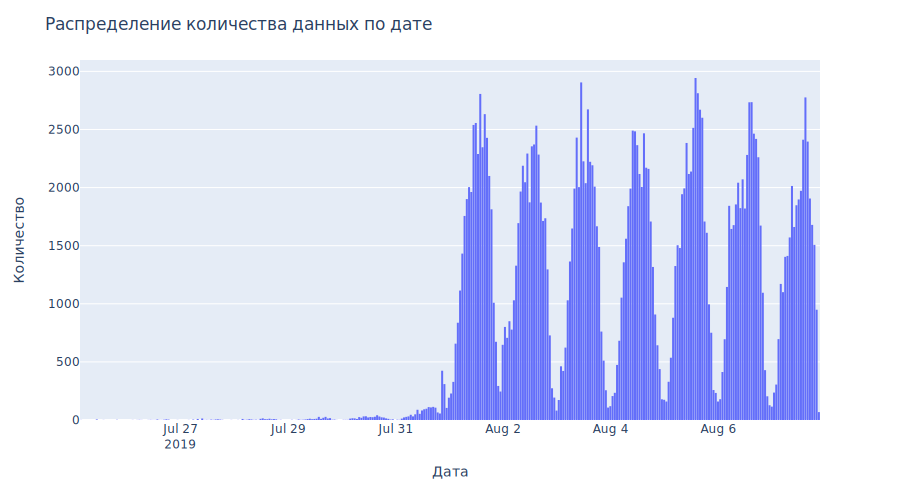

In [12]:
df['date_time'] = df['event_timestamp'].dt.strftime('%Y-%m-%d %H')
fig = px.histogram(df, x='date_time')
fig.update_layout(bargap=0.1)
fig.update_layout(
    title='Распределение количества данных по дате',
    xaxis_title="Дата",
    yaxis_title="Количество",
    width=900, height=500)
fig.show('svg')

Проанализироваав рисунок, можно сказать, что полные данные наступают с 31 июля 21:00 и до конца исследуемого периода - 7 августа 2019 года. С таким периодом и будем работать.

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   device_id_hash   243713 non-null  int64         
 2   event_timestamp  243713 non-null  datetime64[ns]
 3   exp_id           243713 non-null  int64         
 4   date             243713 non-null  datetime64[ns]
 5   date_time        243713 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(2)
memory usage: 13.0+ MB


In [14]:
# Данные с актуальным периодом времени:
data = df[df['event_timestamp'] >= '2019-07-31 21:00']

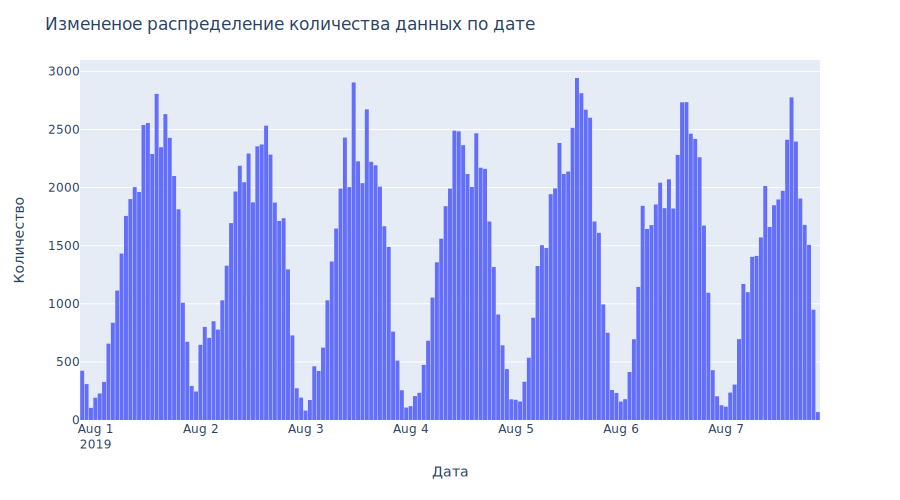

In [15]:
fig = px.histogram(data, x='date_time')
fig.update_layout(bargap=0.1)
fig.update_layout(
    title='Измененое распределение количества данных по дате',
    xaxis_title="Дата",
    yaxis_title="Количество",
    width=900, height=500)
fig.show('svg')

Проверим, как изменилось количество событий и пользователей в новых данных:

In [16]:
print('Разница событий = {}'.format(count_event - data['device_id_hash'].count()))

Разница событий = 1989


In [17]:
print('Разница пользователей = {}'.format(count_id - len(data.groupby('device_id_hash', as_index=False).count())))

Разница пользователей = 13


Убедимся в наличии пользователей из всех трёх экспериментальных групп:

In [18]:
data.groupby('exp_id', as_index=False)['device_id_hash'].agg({'count', 'nunique'})

,count,nunique
exp_id,,
246,79556,2484
247,77293,2517
248,84875,2537


**Вывод:** Медианное значение количества событий на пользователя в логе = 20. Актуальные данные для анализа находятся в интервале с 31 июля 21:00 до 7 августа 2019 года. При этом, мы потерли 2826 событий и потеряли 17 пользователей. В каждой экспериментальной группе есть пользователи для проведения A/A/B-теста и знаем их количество.

# Шаг 4. Воронка событий

## Какие события есть в логах, как часто они встречаются

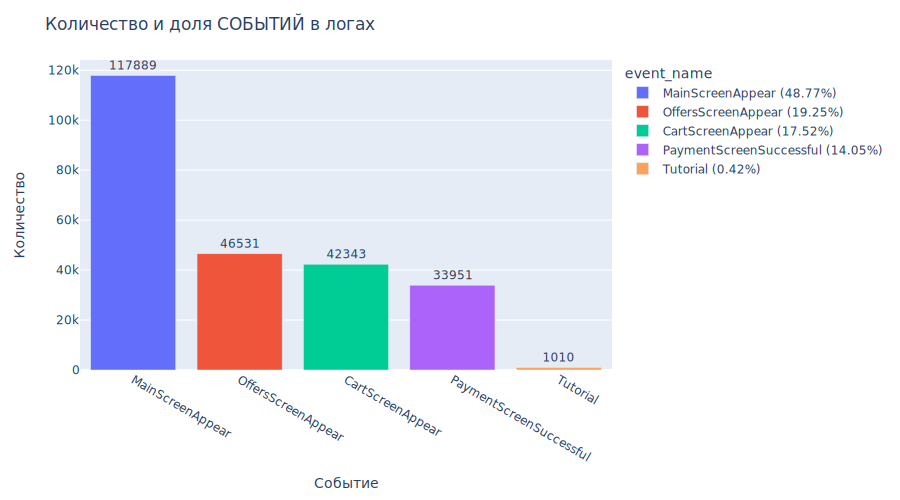

In [19]:
event_sort = data.groupby('event_name', as_index=False).agg(
    {'device_id_hash': 'count'}).sort_values(by='device_id_hash', ascending=False)
event_sort['percent'] = ((event_sort['device_id_hash'] /
                          event_sort['device_id_hash'].sum()) * 100).round(2)

# Графически отобразим результаты
bar_color(
    event_sort,  # DataFrame
    'event_name',  # осьХ
    'device_id_hash',  # ось Y
    'Количество и доля СОБЫТИЙ в логах',  # название рисунка
    'Событие',  # название оси X
    'Количество'  # название оси Y
)

Почти половина событий в логах составляет - MainScreenAppear (показ главного экрана)

## Cколько пользователей совершали каждое из этих событий

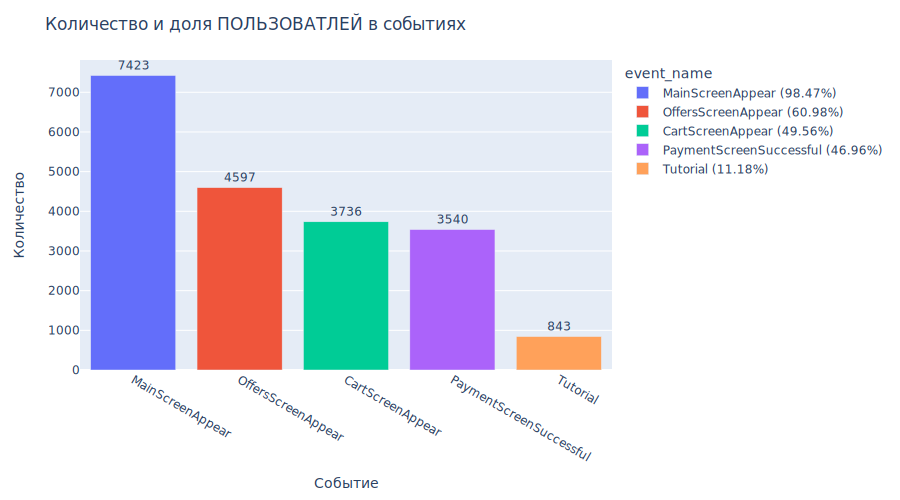

In [20]:
event_sort_id = data.groupby('event_name', as_index=False).agg(
    {'device_id_hash': 'nunique'}).sort_values(by='device_id_hash', ascending=False)

event_sort_id = event_sort_id.rename(
    columns={'device_id_hash': 'user_id_count'})
event_sort_id['percent'] = (
    (event_sort_id['user_id_count'] / data['device_id_hash'].nunique()) * 100).round(2)

# Графически отобразим результаты
bar_color(
    event_sort_id,  # DataFrame
    'event_name',  # осьХ
    'user_id_count',  # осьY
    'Количество и доля ПОЛЬЗОВАТЛЕЙ в событиях',  # название рисунка
    'Событие',  # название осиX
    'Количество'  # название осиY
)

**MainScreenAppear** совершили 98.47% пользователей, 60.96% - **OffersScreenAppear**, 49.56% - **CartScreenAppear**, 46.97% - **PaymentScreenSuccessful**, 11.15% - **Tutorial**.

## В каком порядке происходят события

сначала открывает главную страницу приложения(MainScreenAppear)<br>
&#8595;<br>
потом в каталоге выбирает товары(OffersScreenAppear)<br>
&#8595;<br>
кладёт их в корзину(CartScreenAppear)<br>
&#8595;<br>
и оплачивает(PaymentScreenSuccessful)<br>

## Какая доля пользователей проходит на следующий шаг воронки

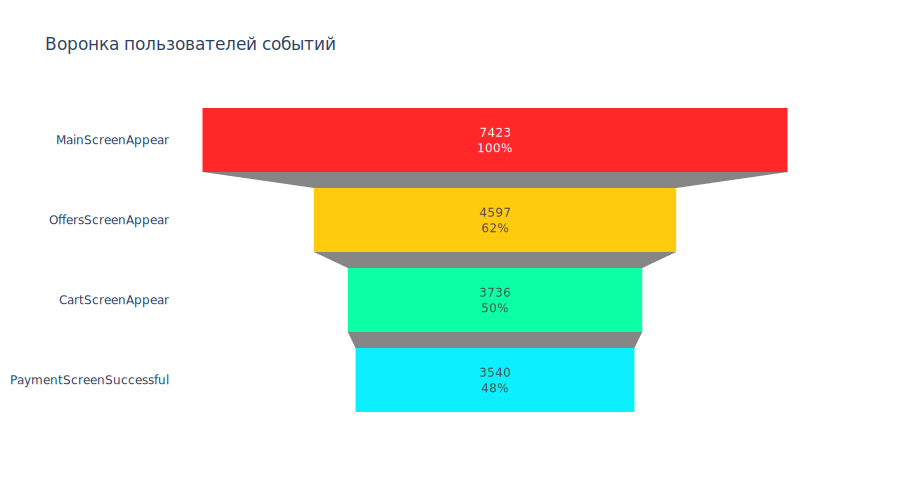

In [21]:
df_funnel = event_sort_id[event_sort_id['event_name'] != 'Tutorial']
fig = go.Figure(go.Funnel(
    y=df_funnel['event_name'],
    x=df_funnel['user_id_count'],
    textposition="inside",
    textinfo="value+percent initial",
    opacity=0.95,
    hoverinfo='y',
    marker={"color": ["#ff1c1c", "#ffc800", "#00ffa1", "#0ef", "#7f00ff"]})
)
fig.update_layout(
    title='Воронка пользователей событий', plot_bgcolor='#ffffff', width=900, height=500)
fig.show('svg')

**Вывод:**
- почти половина событий в логах составляет - MainScreenAppear (показ главного экрана);
- MainScreenAppear совершили 98.47% пользователей, 60.96% - OffersScreenAppear, 49.56% - CartScreenAppear, 46.97% - PaymentScreenSuccessful, 11.15% - Tutorial
- 48% пользователей доходит до совершения покупки.

# Шаг 5. Изучите результаты эксперимента

## Количество пользователей в каждой экспериментальной группе

In [22]:
n_users = data.groupby('exp_id').agg({'device_id_hash': 'nunique'})
n_users.columns = ['n_users']
n_users.index.names = [None]
n_users = n_users.append(pd.Series(name='246+247'))
n_users['n_users'].loc['246+247'] = int(n_users.loc[246] + n_users.loc[247])
n_users['n_users'] = n_users['n_users'].astype(int)
n_users

<ipython-input-22-4d4dafb555da>:4: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



,n_users
246,2484
247,2517
248,2537
246+247,5001


В 246 группе учавствует 2484 пользователей, в 247 группе - 2513, в 248 группе - 2537 пользователей.

## Число пользователей, совершивших каждое событие в каждой из контрольных групп:

Определим в каждом контроьной группе и в каждом событии количество уникальных пользователей:

In [23]:
events = data.groupby('event_name')['device_id_hash'].agg(
    ['count', 'nunique']).sort_values(by='nunique', ascending=False) .reset_index()

events.columns =['event_name', 'n_events', 'n_users']
events

,event_name,n_events,n_users
0,MainScreenAppear,117889,7423
1,OffersScreenAppear,46531,4597
2,CartScreenAppear,42343,3736
3,PaymentScreenSuccessful,33951,3540
4,Tutorial,1010,843


Посчитаем количество уникальных пользователей каждой контрольной группы в каждом событии:

In [24]:
event_name_dict = data['event_name'].unique()
groups = data['exp_id'].unique()
simple_funnel = pd.DataFrame(columns=groups, index=event_name_dict)
for group in simple_funnel:
    for event in simple_funnel.index:
        simple_funnel.loc[event, group] = \
            data[(data['exp_id'] == group) & (
                data['event_name'] == event)]['device_id_hash'].nunique()
simple_funnel.sort_values(by=246, ascending=False)
simple_funnel['total'] = simple_funnel.sum(axis=1)
simple_funnel['246+247'] = simple_funnel[246] + simple_funnel[247]
simple_funnel = simple_funnel.drop(index='Tutorial')
simple_funnel

,247,248,246,total,246+247
MainScreenAppear,2479,2494,2450,7423.0,4929
OffersScreenAppear,1524,1531,1542,4597.0,3066
PaymentScreenSuccessful,1158,1182,1200,3540.0,2358
CartScreenAppear,1239,1231,1266,3736.0,2505


## Статистические критерии разницу между выборками 246 и 247 группами

Выполним проверку гипотезы о равенстве долей Z-критерием:

$$Z = \frac{(P_1 - P_2) - (\pi_1 - \pi_2)}{ \sqrt{P(1 - P)(1/n_1 + 1/n_2)}}$$

В A/B-тестировании чаще всего проверяют гипотезу о равенстве π₁ и π₂, поэтому это значение равняется 0

In [25]:
def z_value(first_group, second_group, alpha, color):
    for i in simple_funnel.index:
        alpha = alpha
        p1 = simple_funnel[first_group][i] / n_users.loc[first_group]
        # пропорция успехов во второй группе:
        p2 = simple_funnel[second_group][i] / n_users.loc[second_group]
        # пропорция успехов в комбинированном датасете:
        p_combined = ((simple_funnel[first_group][i] + simple_funnel[second_group][i]) /
                      (n_users.loc[first_group] + n_users.loc[second_group]))
        # разница пропорций в датасетах
        difference = p1 - p2
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) *
                                        (1/n_users.loc[first_group] + 1/n_users.loc[second_group]))
        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1)
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        print('{} p-значение: {}'.format(i, p_value))
        if (p_value < alpha):
            print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        else:
            print(
                "Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
        print('')

    fig = go.Figure()
    for i, group in enumerate([first_group, second_group]):
        fig.add_trace(go.Funnel(
            name=str(group),
            y=simple_funnel.index,
            x=simple_funnel[group],
            textposition="inside",
            textinfo="value+percent initial",
            connector={"fillcolor": '#c7c7c7'},
            hoverinfo='y',
            marker={"color": colors[i+color]},
            insidetextfont={'color': 'white', 'size': 14}))
    fig.update_layout(title=dict(text='Воронка пользователей событий по контрольным группам ' + str(first_group) + ' и ' + str(second_group)),
                      plot_bgcolor='#ffffff', width=900, height=500)
    fig.show('svg')

**Нулевая гипотеза:** доля между группами 246 и 247 равна

**Альтернативная гипотеза:** доля между группами 246 и 247 различается

MainScreenAppear p-значение: [0.67562177]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: [0.26698769]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: [0.10298395]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: [0.21828121]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



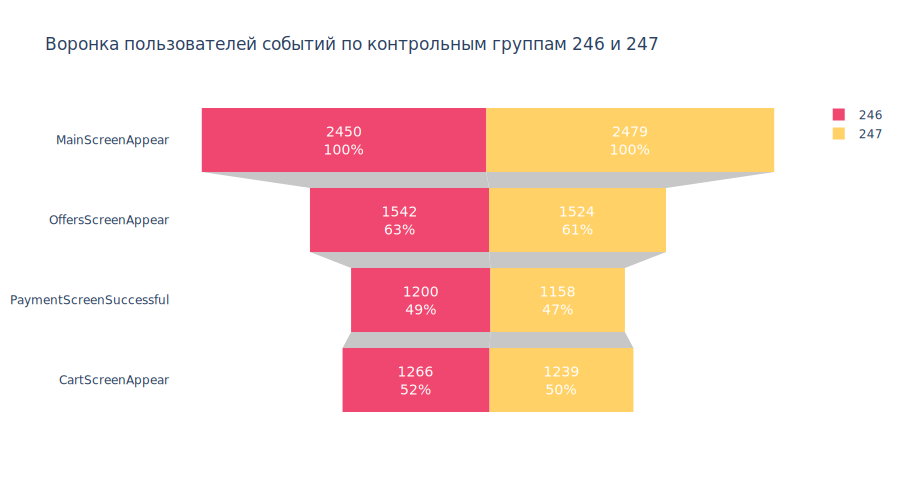

In [26]:
z_value(246,247,0.05,0)

**Нулевая гипотеза:** доля между группами 246 и 247 равна

**Альтернативная гипотеза:** доля между группами 246 и 247 различается

**Вывод:** Ни для оного из событий разница не оказалось значимой обе эти группы можно считать контрольными.

## Статистические критерии разницу между выборками 246 и 248, 247 и 248 группами

**Нулевая гипотеза:** доля между группами 246 и 248 равна

**Альтернативная гипотеза:** доля между группами 246 и 248 различается

MainScreenAppear p-значение: [0.34705881]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: [0.20836205]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: [0.22269359]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: [0.08328413]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



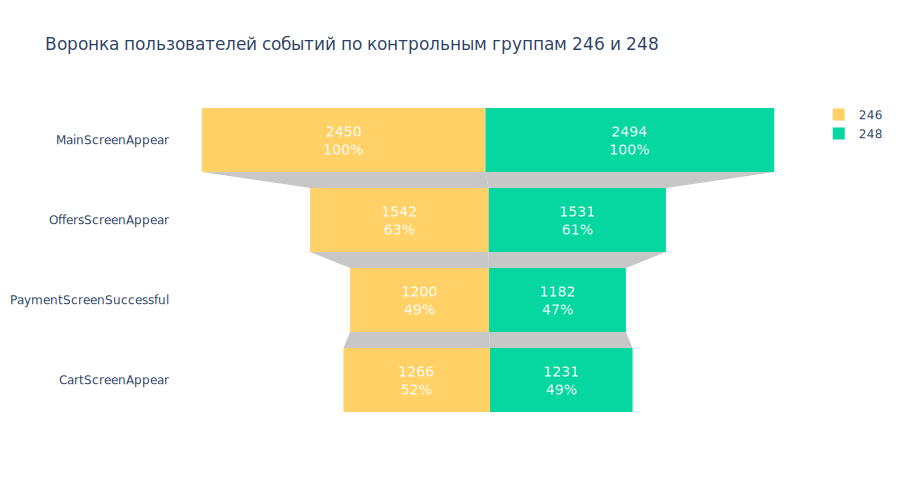

In [27]:
z_value(246,248,0.05,1)

**Нулевая гипотеза:** доля между группами 247 и 248 равна

**Альтернативная гипотеза:** доля между группами 247 и 248 различается

MainScreenAppear p-значение: [0.60016616]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: [0.88359567]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: [0.67754136]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: [0.61695175]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



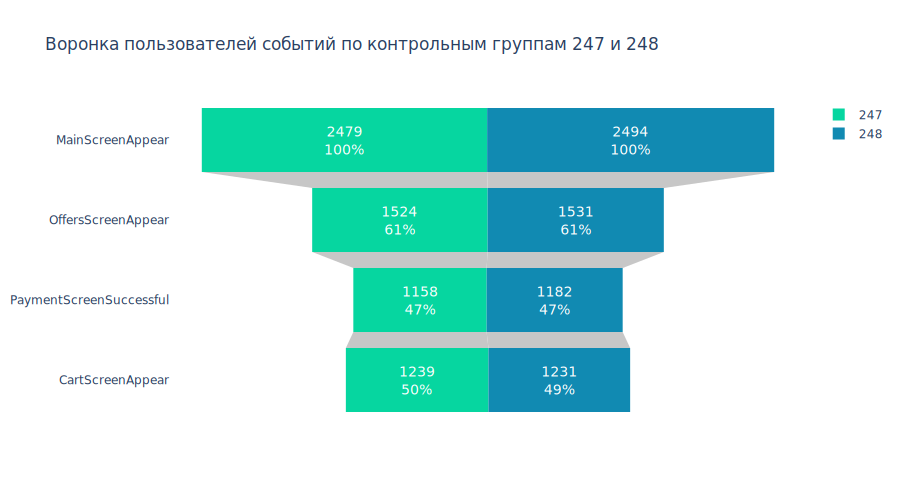

In [28]:
z_value(247,248,0.05,2)

**Вывод:** Ни для оного из событий разница не оказалось значимой из контрольной и экспериментальной группой.

## Статистические критерии разницу между выборками 246+247 и 248 группами:

**Нулевая гипотеза:** доля между группами 246+247 и 248 равна

**Альтернативная гипотеза:** доля между группами 246+247 и 248 различается

MainScreenAppear p-значение: [0.39298915]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: [0.41899828]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: [0.64520577]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: [0.19819341]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



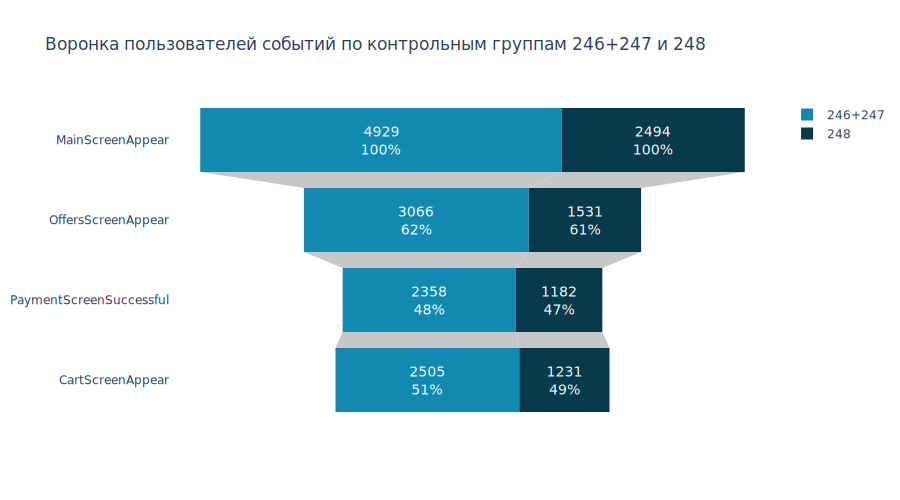

In [29]:
z_value('246+247',248,0.05,3)

**Вывод:** Сравнение результатов с объединенной контрольной группой также не показало значимой разницы.

# Общий вывод

Анализируя гистограмму по дате и времени, можно сказать, что полные данные наступают с 31 июля 21:00 агуста и до конца исследуемого периода - 7 августа 2019 года. С таким периодом и будем работать.

При исследовании воронки событий мы выяснили, что от первого события до оплаты доходит меньше половины пользователей:
- MainScreenAppear совершили 98.47% пользователей, 
- 60.96% OffersScreenAppear
- 49.56% CartScreenAppear,
- 46.97% PaymentScreenSuccessful.


Доля пользователей посетили:
- **MainScreenAppear** - 98.47%. Остальная часть пользователей сразу перешли в каталог или у них не отработала ссылка;
- **OffersScreenAppear** 60.96%. Остальная часть пользователей не увидели каталог товаров. Поскольку клиент уже был заинтересован в приложении, то 30% пользователей не смогли ознакомится с товаром, что говорит о потенциальной некорректной ошибкт приложения.
- **CartScreenAppear** 49.56%. Возможно остальная часть пользователей не смогла найти интересующий его товар.
- **PaymentScreenSuccessful** 46.97%. 3% людей не оплатили заказ. Возможно не хватило средст на карте или не смогли разобраться в способе оплаты. Это небольшая доля пользователей, можно сослаться на человеческий фактор(передумал, не хватило времени или др.)
- **Tutorial** 11.15%. Интересно, что их там заинтересовало. Ведь все основные способы из лида сделать целевым клиентом типовые. 

Мы провели 16 проверок статистических гипотез с уровнем значимости 0.05 (12 из них проверяли разницу между контрольными группами и группой с изменённым шрифтом) и ни одна из них не выявила значимой разницы.

При уровне значимости 0.1 только одна из проверок покажет значимую разницу, между контрольной группой 246 и экспериментальной в доле перехода пользователей в корзину(CartScreenAppear), но эта разница будет не в пользу нашей экспериментальной группы. Но при уровне значимости 0.1 каждый десятый раз можно получать ложный результат, поэтому стоит применить изначально выбранный нами уровень значимости 0.05.

Исходя из результатов данного A/A/B-эксперимента, мы можем судить, что на поведение пользователей изменение шрифта значимого эффекта не оказало. Что можно считать успехом, т.к. целью было узнать не отпугнут ли изменения пользователей. В то же время учитывая результаты эксперимента, если изменение шрифта не продиктовано проблемами в работе приложения, его можно не менять.